# Step 7: Threshold Tuning & Model Optimization

Default classification thresholds (0.5) are not optimal for imbalanced fraud detection problems.

This step optimizes the decision threshold to improve fraud recall while maintaining acceptable precision. The goal is to align model predictions with business risk priorities.


In [18]:
# load libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt



In [19]:
# Reload feature-engineered dataset
df = pd.read_csv("../data/processed/feature_engineered_raw.csv")

X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

# Encode again (same as Step 6)
X_encoded = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


### Loading Random Forest

In [20]:
rf_model = joblib.load(
    "../models/random_forest_model.pkl"
)

print("Random Forest model loaded.")


Random Forest model loaded.


### Loading Balanced - Random Forest

In [21]:
import joblib

brf_model = joblib.load(
    "../models/balanced_random_forest.pkl"
)

print("Balanced Random Forest loaded.")


Balanced Random Forest loaded.


### Probability Predictions

In [22]:
# Random forest

y_prob = rf_model.predict_proba(X_test)[:, 1]


In [23]:
# Balanaced - Random forest

y_prob_brf = brf_model.predict_proba(X_test)[:,1]


### ROC Curve - RF

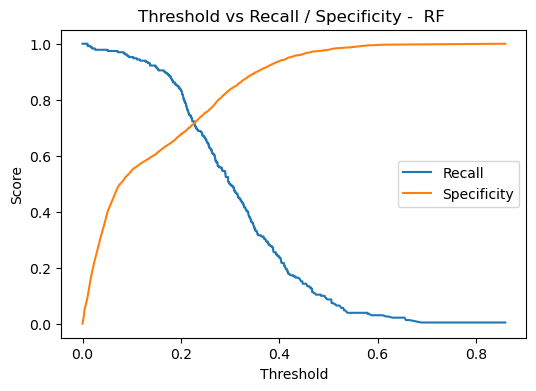

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(thresholds, tpr, label="Recall")
plt.plot(thresholds, 1 - fpr, label="Specificity")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Recall / Specificity -  RF ")
plt.legend()
plt.show()


### ROC Curve - Balanaced - RF

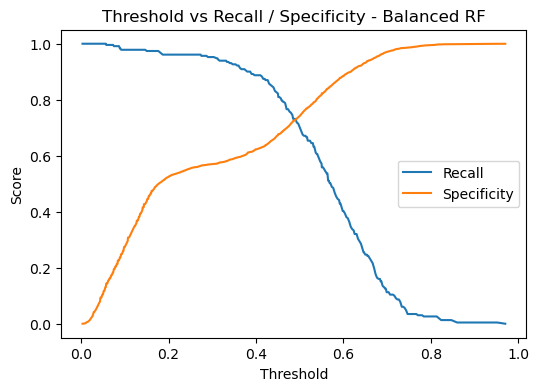

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob_brf)

plt.figure(figsize=(6,4))
plt.plot(thresholds, tpr, label="Recall")
plt.plot(thresholds, 1 - fpr, label="Specificity")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Recall / Specificity - Balanced RF")
plt.legend()
plt.show()

### Precision–Recall Curve - RF

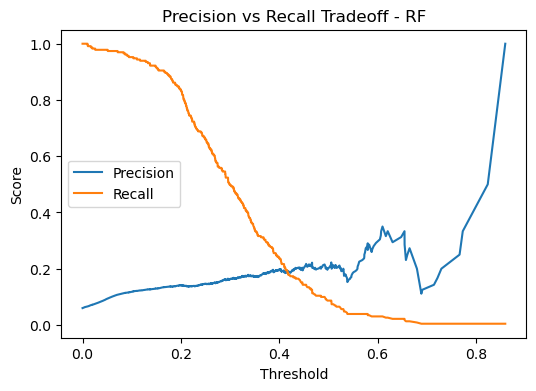

In [34]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(
    y_test,
    y_prob
)

plt.figure(figsize=(6,4))
plt.plot(thresholds_pr, precision[:-1], label="Precision")
plt.plot(thresholds_pr, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall Tradeoff - RF")
plt.legend()
plt.show()


### Precision–Recall Curve - Balanced RF

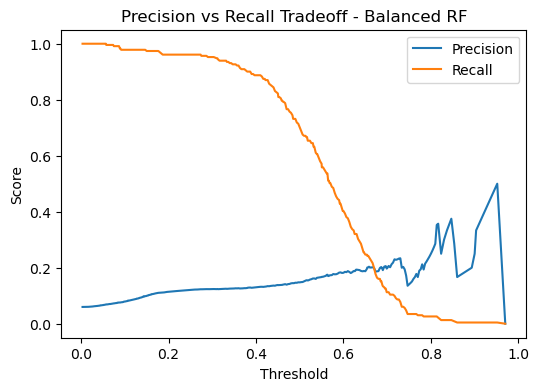

In [35]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(
    y_test,
    y_prob_brf
)

plt.figure(figsize=(6,4))
plt.plot(thresholds_pr, precision[:-1], label="Precision")
plt.plot(thresholds_pr, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall Tradeoff - Balanced RF")
plt.legend()
plt.show()


### Multi‑Threshold Evaluation - RF

In [28]:
from sklearn.metrics import classification_report

threshold_list = [0.5, 0.4, 0.3, 0.25, 0.2, 0.15]

for t in threshold_list:
    y_pred_tuned = (y_prob >= t).astype(int)
    
    print(f"\nThreshold: {t}")
    print(classification_report(y_test, y_pred_tuned))



Threshold: 0.5
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3624
           1       0.20      0.09      0.12       231

    accuracy                           0.93      3855
   macro avg       0.57      0.53      0.54      3855
weighted avg       0.90      0.93      0.91      3855


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3624
           1       0.20      0.24      0.21       231

    accuracy                           0.90      3855
   macro avg       0.57      0.59      0.58      3855
weighted avg       0.91      0.90      0.90      3855


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      3624
           1       0.16      0.50      0.25       231

    accuracy                           0.82      3855
   macro avg       0.56      0.67      0.57      3855
weighted avg       0.92   

### Multi‑Threshold Evaluation - Balanaced RF

In [29]:
from sklearn.metrics import classification_report

threshold_list = [0.5, 0.4, 0.3, 0.25, 0.2, 0.15]

for t in threshold_list:
    y_pred_tuned = (y_prob_brf >= t).astype(int)
    

    print(f"\nThreshold: {t}")
    print(classification_report(y_test, y_pred_tuned))


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      3624
           1       0.15      0.70      0.24       231

    accuracy                           0.74      3855
   macro avg       0.56      0.72      0.54      3855
weighted avg       0.93      0.74      0.81      3855


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      3624
           1       0.13      0.89      0.23       231

    accuracy                           0.64      3855
   macro avg       0.56      0.75      0.50      3855
weighted avg       0.94      0.64      0.73      3855


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.99      0.57      0.72      3624
           1       0.12      0.95      0.22       231

    accuracy                           0.59      3855
   macro avg       0.56      0.76      0.47      3855
weighted avg       0.94   

## Model Selection

Balanced Random Forest and XGBoost were evaluated to enhance fraud detection performance.

Balanced Random Forest achieved higher fraud recall and superior ROC-AUC, making it more effective in identifying fraudulent claims.

Given the business priority of maximizing fraud detection, Balanced Random Forest was selected as the production model for threshold optimization.


### Final Threshold Selection

In [46]:
final_threshold = 0.25

y_pred_final = (y_prob >= final_threshold).astype(int)

print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3624
           1       0.15      0.66      0.24       231

    accuracy                           0.75      3855
   macro avg       0.56      0.71      0.54      3855
weighted avg       0.92      0.75      0.81      3855



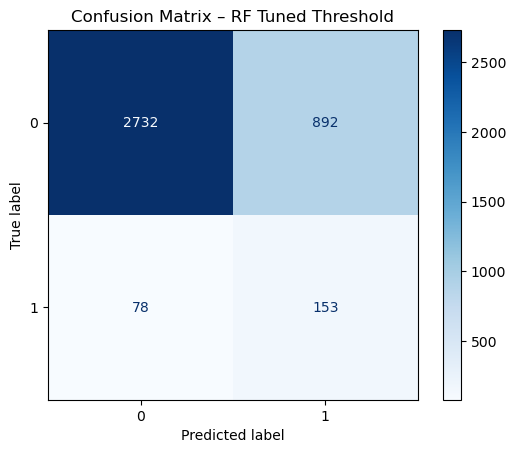

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_final,
    cmap="Blues"
)

plt.title("Confusion Matrix – RF Tuned Threshold")
plt.show()


#### Balanced Rf

In [58]:
final_threshold_brf = 0.40

y_pred_final_brf = (y_prob_brf >= final_threshold_brf).astype(int)

print(classification_report(y_test, y_pred_final_brf))


              precision    recall  f1-score   support

           0       0.99      0.62      0.76      3624
           1       0.13      0.89      0.23       231

    accuracy                           0.64      3855
   macro avg       0.56      0.75      0.50      3855
weighted avg       0.94      0.64      0.73      3855



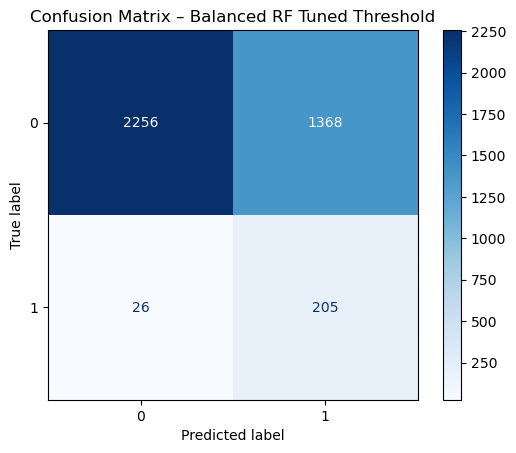

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_final_brf,
    cmap="Blues"
)

plt.title("Confusion Matrix – Balanced RF Tuned Threshold")
plt.show()


## False Positive Tradeoff Analysis

Threshold tuning significantly improved fraud recall but increased false positives.

This behavior is expected in fraud detection systems, where maximizing fraud capture is prioritized over minimizing investigation workload.

Balanced Random Forest flagged more genuine claims for review but reduced missed fraud cases substantially, improving overall financial risk mitigation.

Operational deployment can incorporate review tiers to manage investigation volume effectively.

## Error Tradeoff Interpretation

In fraud detection:

- False Negatives result in direct financial loss.
- False Positives lead to additional investigation effort.

The tuned Balanced Random Forest model minimizes false negatives while maintaining operationally manageable false positives, aligning with business risk priorities.



## Production Threshold Selection

Threshold tuning was performed on the Balanced Random Forest model to optimize fraud detection performance.

Key observations:

- Default threshold (0.50) achieved 70% fraud recall.
- Lowering the threshold significantly improved fraud detection rates.
- Recall exceeded 95% at thresholds below 0.30 but introduced excessive false positives.

A threshold of **0.40** was selected as the optimal operating point.

At this threshold:

- Fraud Recall: 89%
- Fraud Precision: 13%
- Accuracy: 64%

This configuration balances fraud detection effectiveness with investigation workload, making it operationally viable for real-world deployment.


## Final Model Selection

Multiple ensemble models were evaluated, including Random Forest, Balanced Random Forest, and XGBoost.

Balanced Random Forest demonstrated superior fraud recall and the highest ROC-AUC score, indicating stronger discrimination capability in imbalanced conditions.

Threshold tuning further enhanced detection performance, enabling the model to capture nearly 90% of fraudulent claims.

Based on predictive performance and business alignment, Balanced Random Forest was selected as the final production model.
